In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import resnet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'train_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'test_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2925 	 Test size: 643
Image size: 256x256


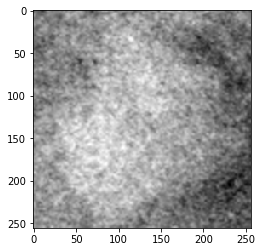

Label: 1
FN: Mass-Training_P_00106_LEFT_CC.png


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(2925, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_resnet50(verbose=False, fc_size=256, output = 2, dropout=None):
    
    from tensorflow.keras.applications import resnet50
    
    resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet50 = models.Sequential()
    resnet50.add(resnet50_base)

    resnet50.add(layers.Flatten())
    if dropout is not None:
        resnet50.add(layers.Dropout(dropout))
    resnet50.add(layers.Dense(fc_size, activation='relu'))
    resnet50.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    resnet50_base.trainable = False
    
    if verbose:
        resnet50_base.summary()
        resnet50.summary()

    return resnet50

In [12]:
resnet = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in resnet.layers:
    layer.trainable = False
resnet_maxpool = resnet.get_layer('conv5_block3_out').output
FeatureFlatten = Flatten()(resnet_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_resnet = Model(inputs = resnet.input, outputs = predictions)
new_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
resnet50_calc_or_mass_best_Adam = new_resnet

In [14]:
resnet50_calc_or_mass_best_RMSprop = new_resnet

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet50_calc_or_mass_best_Adam = resnet50_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 3.5182 - recall: 0.5404
Epoch 00001: val_loss improved from inf to 0.60903, saving model to ../model/resnet50_calc_or_mass_best_Adam.h5
11/11 [==============================] - 27s 2s/step - loss: 3.2685 - recall: 0.5464 - val_loss: 0.6090 - val_recall: 0.6188
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5610 - recall: 0.7320
Epoch 00002: val_loss improved from 0.60903 to 0.58368, saving model to ../model/resnet50_calc_or_mass_best_Adam.h5
11/11 [==============================] - 25s 2s/step - loss: 0.5473 - recall: 0.7401 - val_loss: 0.5837 - val_recall: 0.7145
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4633 - recall: 0.7898
Epoch 00003: val_loss improved from 0.58368 to 0.55529, saving model to ../m

10/11 [==========================>...] - ETA: 1s - loss: 0.3328 - recall: 0.8426
Epoch 00027: val_loss did not improve from 0.40510
11/11 [==============================] - 21s 2s/step - loss: 0.3398 - recall: 0.8457 - val_loss: 0.4226 - val_recall: 0.7983
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3458 - recall: 0.8492
Epoch 00028: val_loss did not improve from 0.40510
11/11 [==============================] - 21s 2s/step - loss: 0.3448 - recall: 0.8501 - val_loss: 0.4474 - val_recall: 0.7915
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3349 - recall: 0.8523
Epoch 00029: val_loss did not improve from 0.40510
11/11 [==============================] - 21s 2s/step - loss: 0.3293 - recall: 0.8565 - val_loss: 0.4764 - val_recall: 0.7726
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2899 - recall: 0.8704
Epoch 00030: val_loss did not improve from 0.40510
11/11 [==============================] - 20s 2s/step - los

In [17]:
models.save_model(resnet50_calc_or_mass_best_Adam, '../model/resnet50_calc_or_mass_end_Adam.h5')

In [18]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 52
Epoch [opt]: 22
Valid recall [end]: 0.8051
Valid recall [opt]: 0.8120
Test recall [end]:  0.8072
Test recall [opt]:  0.8087
Valid loss [end]: 0.4286
Valid loss [opt]: 0.4051
Test loss [end]:  0.4445
Test loss [opt]:  0.4147


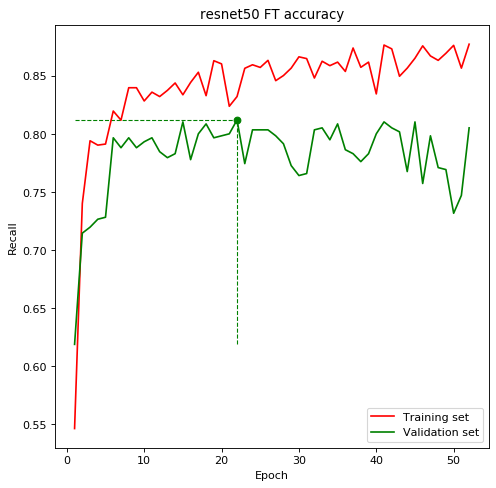

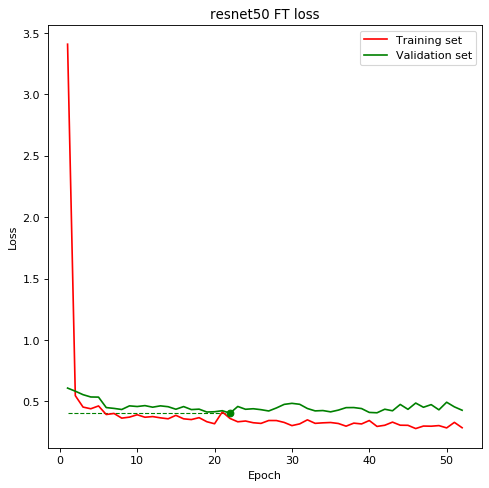

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [14]:
resnet50_calc_or_mass_best_SGD = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [15]:
# Train
history_resnet50_calc_or_mass_best_SGD = resnet50_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3922 - recall: 0.5156
Epoch 00001: val_loss improved from inf to 1.06069, saving model to ../model/resnet50_calc_or_mass_best_SGD.h5
11/11 [==============================] - 25s 2s/step - loss: 1.3932 - recall: 0.5192 - val_loss: 1.0607 - val_recall: 0.4974
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2527 - recall: 0.5562
Epoch 00002: val_loss improved from 1.06069 to 0.97004, saving model to ../model/resnet50_calc_or_mass_best_SGD.h5
11/11 [==============================] - 23s 2s/step - loss: 1.2642 - recall: 0.5490 - val_loss: 0.9700 - val_recall: 0.5197
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1407 - recall: 0.5657
Epoch 00003: val_loss did not improve from 0.97004
11/11 [====================

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7744 - recall: 0.6726
Epoch 00027: val_loss did not improve from 0.64233
11/11 [==============================] - 21s 2s/step - loss: 0.7635 - recall: 0.6786 - val_loss: 0.6545 - val_recall: 0.6530
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6803 - recall: 0.7155
Epoch 00028: val_loss did not improve from 0.64233
11/11 [==============================] - 20s 2s/step - loss: 0.6920 - recall: 0.7044 - val_loss: 0.6553 - val_recall: 0.6393
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7104 - recall: 0.6906
Epoch 00029: val_loss did not improve from 0.64233
11/11 [==============================] - 21s 2s/step - loss: 0.7175 - recall: 0.6882 - val_loss: 0.6591 - val_recall: 0.6547
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6913 - recall: 0.6936
Epoch 00030: val_loss did not improve from 0.64233
11/11 [==============================] - 21s 

Epoch 85/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5512 - recall: 0.7685
Epoch 00085: val_loss did not improve from 0.52683
11/11 [==============================] - 21s 2s/step - loss: 0.5610 - recall: 0.7622 - val_loss: 0.6036 - val_recall: 0.7077
Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5365 - recall: 0.7416
Epoch 00086: val_loss did not improve from 0.52683
11/11 [==============================] - 22s 2s/step - loss: 0.5315 - recall: 0.7485 - val_loss: 0.5959 - val_recall: 0.6906
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5760 - recall: 0.7359
Epoch 00087: val_loss did not improve from 0.52683
11/11 [==============================] - 22s 2s/step - loss: 0.5621 - recall: 0.7378 - val_loss: 0.5566 - val_recall: 0.7265
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5603 - recall: 0.7399
Epoch 00088: val_loss improved from 0.52683 to 0.51584, saving model to ../model/resnet50_calc_o

10/11 [==========================>...] - ETA: 1s - loss: 0.5040 - recall: 0.7586
Epoch 00115: val_loss did not improve from 0.51584
11/11 [==============================] - 22s 2s/step - loss: 0.5133 - recall: 0.7576 - val_loss: 0.5188 - val_recall: 0.7179
Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5182 - recall: 0.7483
Epoch 00116: val_loss did not improve from 0.51584
11/11 [==============================] - 29s 3s/step - loss: 0.5213 - recall: 0.7485 - val_loss: 0.5614 - val_recall: 0.7179
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4971 - recall: 0.7727
Epoch 00117: val_loss did not improve from 0.51584
11/11 [==============================] - 24s 2s/step - loss: 0.4886 - recall: 0.7805 - val_loss: 0.5529 - val_recall: 0.7248
Epoch 118/300
10/11 [==========================>...] - ETA: 5s - loss: 0.5004 - recall: 0.7652
Epoch 00118: val_loss did not improve from 0.51584
11/11 [==============================] - 83s 8s/step - 

In [16]:
models.save_model(resnet50_calc_or_mass_best_SGD, '../model/resnet50_calc_or_mass_end_SGD.h5')

In [17]:
tra_loss_fe = history_resnet50_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 118
Epoch [opt]: 88
Valid recall [end]: 0.7145
Valid recall [opt]: 0.7419
Test recall [end]:  0.7263
Test recall [opt]:  0.7030
Valid loss [end]: 0.5654
Valid loss [opt]: 0.5158
Test loss [end]:  0.5582
Test loss [opt]:  0.5821


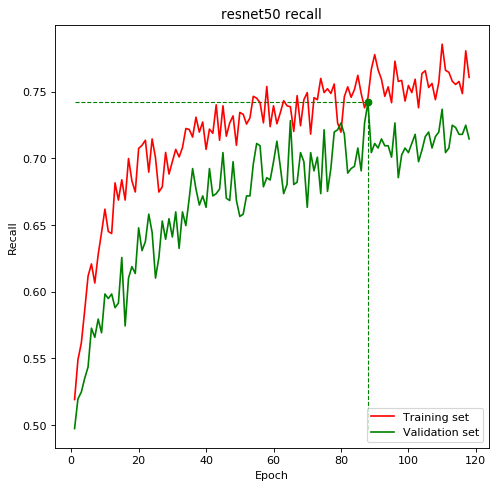

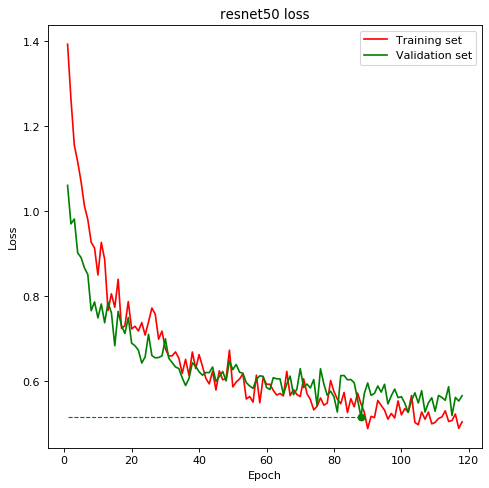

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet50_calc_or_mass_best_RMSprop = resnet50_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 2s - loss: 13.8987 - recall: 0.5143
Epoch 00001: val_loss improved from inf to 0.79158, saving model to ../model/resnet50_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 52s 5s/step - loss: 13.0764 - recall: 0.5137 - val_loss: 0.7916 - val_recall: 0.5402
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4093 - recall: 0.5800
Epoch 00002: val_loss improved from 0.79158 to 0.72580, saving model to ../model/resnet50_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 35s 3s/step - loss: 1.3652 - recall: 0.5957 - val_loss: 0.7258 - val_recall: 0.6701
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1460 - recall: 0.6507
Epoch 00003: val_loss improved from 0.72580 to 0.50180, saving model

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4243 - recall: 0.8215
Epoch 00028: val_loss did not improve from 0.40770
11/11 [==============================] - 21s 2s/step - loss: 0.4326 - recall: 0.8153 - val_loss: 0.4892 - val_recall: 0.7487
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3865 - recall: 0.8401
Epoch 00029: val_loss did not improve from 0.40770
11/11 [==============================] - 22s 2s/step - loss: 0.3752 - recall: 0.8457 - val_loss: 0.4383 - val_recall: 0.8120
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4309 - recall: 0.8148
Epoch 00030: val_loss did not improve from 0.40770
11/11 [==============================] - 22s 2s/step - loss: 0.4152 - recall: 0.8161 - val_loss: 0.4819 - val_recall: 0.7487
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4229 - recall: 0.8047
Epoch 00031: val_loss did not improve from 0.40770
11/11 [==============================] - 22s 

10/11 [==========================>...] - ETA: 1s - loss: 0.3119 - recall: 0.8641
Epoch 00088: val_loss did not improve from 0.39606
11/11 [==============================] - 22s 2s/step - loss: 0.3071 - recall: 0.8658 - val_loss: 0.5299 - val_recall: 0.8051
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2757 - recall: 0.8822
Epoch 00089: val_loss did not improve from 0.39606
11/11 [==============================] - 21s 2s/step - loss: 0.2739 - recall: 0.8837 - val_loss: 0.5337 - val_recall: 0.7812
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2276 - recall: 0.9015
Epoch 00090: val_loss did not improve from 0.39606
11/11 [==============================] - 22s 2s/step - loss: 0.2390 - recall: 0.8944 - val_loss: 0.4301 - val_recall: 0.8171
Epoch 00090: early stopping


In [17]:
models.save_model(resnet50_calc_or_mass_best_RMSprop, '../model/resnet50_calc_or_mass_end_RMSprop.h5')

In [18]:
tra_loss_fe = history_resnet50_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 90
Epoch [opt]: 60
Valid recall [end]: 0.8171
Valid recall [opt]: 0.8137
Test recall [end]:  0.8383
Test recall [opt]:  0.8476
Valid loss [end]: 0.4301
Valid loss [opt]: 0.3961
Test loss [end]:  0.4471
Test loss [opt]:  0.4250


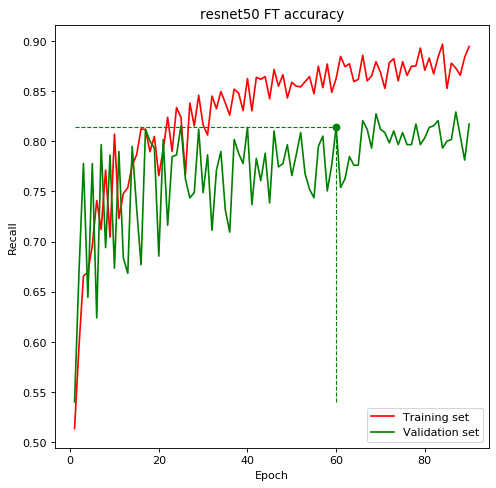

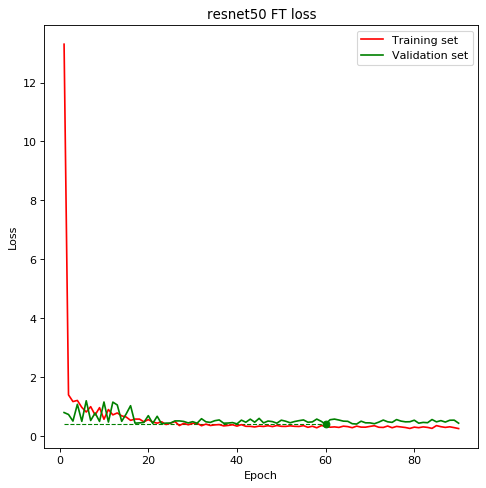

In [19]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [20]:
resnet50_calc_or_mass_best_Adadelta = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [21]:
# Train
history_resnet50_calc_or_mass_best_Adadelta = resnet50_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3162 - recall: 0.5023
Epoch 00001: val_loss improved from inf to 1.11267, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 23s 2s/step - loss: 1.3092 - recall: 0.5053 - val_loss: 1.1127 - val_recall: 0.5248
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3584 - recall: 0.5109
Epoch 00002: val_loss improved from 1.11267 to 1.09013, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.3761 - recall: 0.5038 - val_loss: 1.0901 - val_recall: 0.5231
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3404 - recall: 0.5168
Epoch 00003: val_loss improved from 1.09013 to 0.99818, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [=================

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0981 - recall: 0.5446
Epoch 00029: val_loss did not improve from 0.94050
11/11 [==============================] - 20s 2s/step - loss: 1.1228 - recall: 0.5441 - val_loss: 0.9446 - val_recall: 0.5453
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1418 - recall: 0.5555
Epoch 00030: val_loss did not improve from 0.94050
11/11 [==============================] - 21s 2s/step - loss: 1.1482 - recall: 0.5483 - val_loss: 0.9816 - val_recall: 0.5231
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1590 - recall: 0.5477
Epoch 00031: val_loss did not improve from 0.94050
11/11 [==============================] - 21s 2s/step - loss: 1.1505 - recall: 0.5547 - val_loss: 0.9905 - val_recall: 0.5231
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1320 - recall: 0.5539
Epoch 00032: val_loss did not improve from 0.94050
11/11 [==============================] - 21s 

Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0156 - recall: 0.5805
Epoch 00059: val_loss did not improve from 0.85948
11/11 [==============================] - 21s 2s/step - loss: 1.0136 - recall: 0.5803 - val_loss: 0.9067 - val_recall: 0.5521
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0241 - recall: 0.5859
Epoch 00060: val_loss did not improve from 0.85948
11/11 [==============================] - 21s 2s/step - loss: 1.0592 - recall: 0.5824 - val_loss: 0.8811 - val_recall: 0.5880
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0256 - recall: 0.5673
Epoch 00061: val_loss did not improve from 0.85948
11/11 [==============================] - 20s 2s/step - loss: 1.0280 - recall: 0.5699 - val_loss: 0.8610 - val_recall: 0.5556
Epoch 62/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0682 - recall: 0.5758
Epoch 00062: val_loss did not improve from 0.85948
11/11 [==============================] - 21s 

11/11 [==============================] - 21s 2s/step - loss: 0.9361 - recall: 0.6322 - val_loss: 0.8190 - val_recall: 0.5829
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0056 - recall: 0.5909
Epoch 00089: val_loss improved from 0.81905 to 0.81848, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 0.9930 - recall: 0.6026 - val_loss: 0.8185 - val_recall: 0.5915
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0229 - recall: 0.5875
Epoch 00090: val_loss improved from 0.81848 to 0.79331, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0127 - recall: 0.5881 - val_loss: 0.7933 - val_recall: 0.5761
Epoch 91/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9539 - recall: 0.6367
Epoch 00091: val_loss did not improve from 0.79331
11/11 [==============================] - 21s 2s/step

Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8991 - recall: 0.6128
Epoch 00118: val_loss did not improve from 0.77118
11/11 [==============================] - 20s 2s/step - loss: 0.9168 - recall: 0.6056 - val_loss: 0.7848 - val_recall: 0.5932
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0102 - recall: 0.5828
Epoch 00119: val_loss improved from 0.77118 to 0.76968, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0113 - recall: 0.5845 - val_loss: 0.7697 - val_recall: 0.5897
Epoch 120/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9205 - recall: 0.6052
Epoch 00120: val_loss did not improve from 0.76968
11/11 [==============================] - 20s 2s/step - loss: 0.9335 - recall: 0.6049 - val_loss: 0.7785 - val_recall: 0.5863
Epoch 121/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9145 - recall: 0.6164
Epoch 00121: val_loss d

Epoch 148/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8823 - recall: 0.6477
Epoch 00148: val_loss did not improve from 0.71937
11/11 [==============================] - 21s 2s/step - loss: 0.8858 - recall: 0.6477 - val_loss: 0.7403 - val_recall: 0.6034
Epoch 149/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9931 - recall: 0.6035
Epoch 00149: val_loss did not improve from 0.71937
11/11 [==============================] - 20s 2s/step - loss: 0.9856 - recall: 0.6041 - val_loss: 0.7607 - val_recall: 0.6017
Epoch 150/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8587 - recall: 0.6355
Epoch 00150: val_loss did not improve from 0.71937
11/11 [==============================] - 20s 2s/step - loss: 0.8748 - recall: 0.6330 - val_loss: 0.7780 - val_recall: 0.5726
Epoch 151/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9052 - recall: 0.6281
Epoch 00151: val_loss did not improve from 0.71937
11/11 [==============================] - 

Epoch 178/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8162 - recall: 0.6633
Epoch 00178: val_loss did not improve from 0.69192
11/11 [==============================] - 20s 2s/step - loss: 0.8307 - recall: 0.6634 - val_loss: 0.7592 - val_recall: 0.5897
Epoch 179/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8947 - recall: 0.6430
Epoch 00179: val_loss did not improve from 0.69192
11/11 [==============================] - 20s 2s/step - loss: 0.9113 - recall: 0.6429 - val_loss: 0.7250 - val_recall: 0.6205
Epoch 180/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8618 - recall: 0.6397
Epoch 00180: val_loss did not improve from 0.69192
11/11 [==============================] - 20s 2s/step - loss: 0.8468 - recall: 0.6459 - val_loss: 0.7505 - val_recall: 0.5915
Epoch 181/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8464 - recall: 0.6422
Epoch 00181: val_loss did not improve from 0.69192
11/11 [==============================] - 

Epoch 208/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8245 - recall: 0.6672
Epoch 00208: val_loss improved from 0.66276 to 0.65196, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 0.8161 - recall: 0.6719 - val_loss: 0.6520 - val_recall: 0.6462
Epoch 209/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8217 - recall: 0.6498
Epoch 00209: val_loss did not improve from 0.65196
11/11 [==============================] - 21s 2s/step - loss: 0.8192 - recall: 0.6512 - val_loss: 0.7158 - val_recall: 0.6103
Epoch 210/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8919 - recall: 0.6414
Epoch 00210: val_loss improved from 0.65196 to 0.63618, saving model to ../model/resnet50_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 23s 2s/step - loss: 0.8823 - recall: 0.6444 - val_loss: 0.6362 - val_recall: 0.6564
Epoch 211/300
10/11 [==========================>.

Epoch 238/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8481 - recall: 0.6453
Epoch 00238: val_loss did not improve from 0.62048
11/11 [==============================] - 21s 2s/step - loss: 0.8195 - recall: 0.6474 - val_loss: 0.6974 - val_recall: 0.6137
Epoch 239/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8490 - recall: 0.6477
Epoch 00239: val_loss did not improve from 0.62048
11/11 [==============================] - 22s 2s/step - loss: 0.8461 - recall: 0.6470 - val_loss: 0.6925 - val_recall: 0.6325
Epoch 240/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7953 - recall: 0.6616
Epoch 00240: val_loss did not improve from 0.62048
11/11 [==============================] - 21s 2s/step - loss: 0.7949 - recall: 0.6641 - val_loss: 0.6924 - val_recall: 0.6103
Epoch 241/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7441 - recall: 0.6883
Epoch 00241: val_loss did not improve from 0.62048
11/11 [==============================] - 

In [23]:
models.save_model(resnet50_calc_or_mass_best_Adadelta, '../model/resnet50_calc_or_mass_end_Adadelta.h5')

In [24]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 250
Epoch [opt]: 220
Valid recall [end]: 0.6581
Valid recall [opt]: 0.6479
Test recall [end]:  0.6096
Test recall [opt]:  0.6019
Valid loss [end]: 0.6274
Valid loss [opt]: 0.6205
Test loss [end]:  0.7248
Test loss [opt]:  0.7505


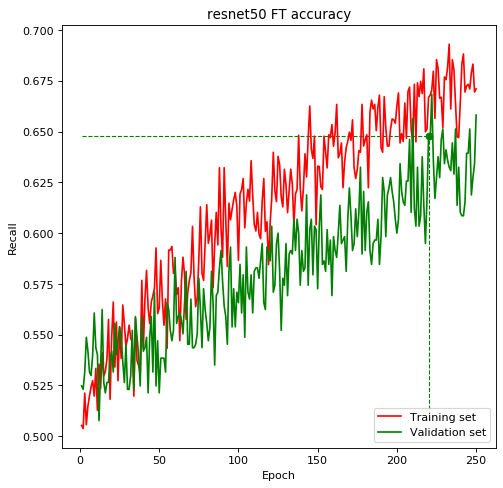

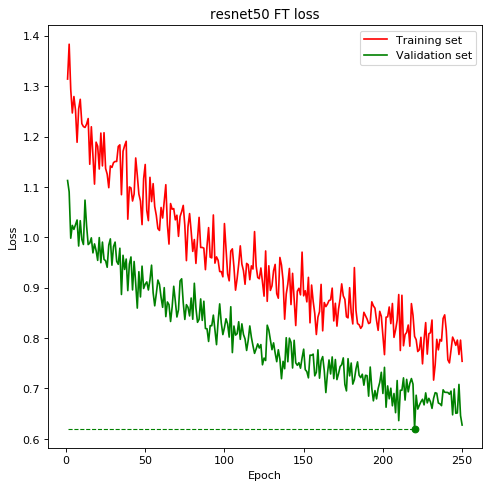

In [25]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [26]:
resnet50_calc_or_mass_best_Adagrad = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [27]:
# Train
history_resnet50_calc_or_mass_best_Adagrad = resnet50_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2691 - recall: 0.5126
Epoch 00001: val_loss improved from inf to 0.84513, saving model to ../model/resnet50_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 22s 2s/step - loss: 1.2523 - recall: 0.5182 - val_loss: 0.8451 - val_recall: 0.5402
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0461 - recall: 0.6027
Epoch 00002: val_loss improved from 0.84513 to 0.83443, saving model to ../model/resnet50_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 21s 2s/step - loss: 1.0440 - recall: 0.6056 - val_loss: 0.8344 - val_recall: 0.5761
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9436 - recall: 0.6162
Epoch 00003: val_loss improved from 0.83443 to 0.76025, saving model to ../model/resnet50_calc_or_mass_best_Adagrad.h5
11/11 [====================

10/11 [==========================>...] - ETA: 1s - loss: 0.4826 - recall: 0.7664
Epoch 00057: val_loss did not improve from 0.52732
11/11 [==============================] - 21s 2s/step - loss: 0.4797 - recall: 0.7699 - val_loss: 0.5600 - val_recall: 0.7179
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4761 - recall: 0.7811
Epoch 00058: val_loss did not improve from 0.52732
11/11 [==============================] - 20s 2s/step - loss: 0.4769 - recall: 0.7834 - val_loss: 0.5781 - val_recall: 0.7026
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5077 - recall: 0.7727
Epoch 00059: val_loss did not improve from 0.52732
11/11 [==============================] - 21s 2s/step - loss: 0.4981 - recall: 0.7763 - val_loss: 0.5509 - val_recall: 0.6974
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4868 - recall: 0.7859
Epoch 00060: val_loss did not improve from 0.52732
11/11 [==============================] - 22s 2s/step - los

Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4656 - recall: 0.7727
Epoch 00087: val_loss did not improve from 0.51520
11/11 [==============================] - 21s 2s/step - loss: 0.4642 - recall: 0.7749 - val_loss: 0.5353 - val_recall: 0.7197
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4577 - recall: 0.7753
Epoch 00088: val_loss did not improve from 0.51520
11/11 [==============================] - 20s 2s/step - loss: 0.4586 - recall: 0.7781 - val_loss: 0.5227 - val_recall: 0.7265
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4358 - recall: 0.7786
Epoch 00089: val_loss did not improve from 0.51520
11/11 [==============================] - 20s 2s/step - loss: 0.4421 - recall: 0.7789 - val_loss: 0.5308 - val_recall: 0.7350
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4284 - recall: 0.7977
Epoch 00090: val_loss did not improve from 0.51520
11/11 [==============================] - 21s 

In [28]:
models.save_model(resnet50_calc_or_mass_best_Adagrad, '../model/resnet50_calc_or_mass_end_Adagrad.h5')

In [29]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 108
Epoch [opt]: 78
Valid recall [end]: 0.7162
Valid recall [opt]: 0.7368
Test recall [end]:  0.7589
Test recall [opt]:  0.7527
Valid loss [end]: 0.5461
Valid loss [opt]: 0.5152
Test loss [end]:  0.4949
Test loss [opt]:  0.4963


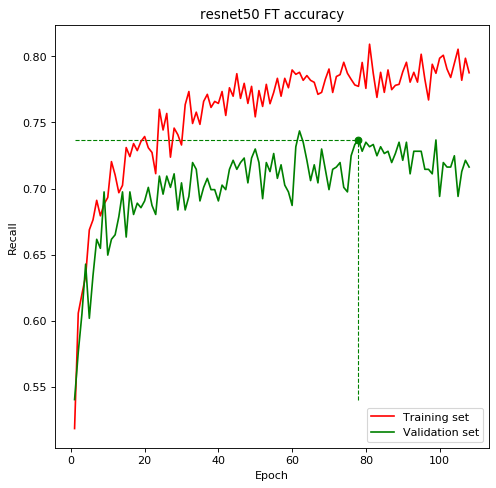

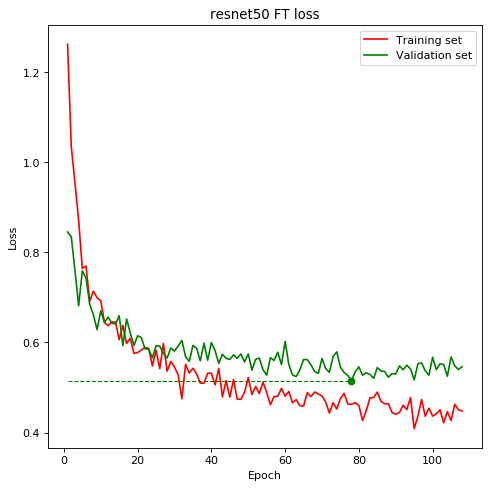

In [30]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [31]:
resnet50_calc_or_mass_best_Adamax = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [32]:
# Train
history_resnet50_calc_or_mass_best_Adamax = resnet50_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2165 - recall: 0.6372
Epoch 00001: val_loss improved from inf to 0.65038, saving model to ../model/resnet50_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 23s 2s/step - loss: 1.1662 - recall: 0.6474 - val_loss: 0.6504 - val_recall: 0.7026
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6204 - recall: 0.7306
Epoch 00002: val_loss improved from 0.65038 to 0.62400, saving model to ../model/resnet50_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 21s 2s/step - loss: 0.6300 - recall: 0.7249 - val_loss: 0.6240 - val_recall: 0.6923
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5588 - recall: 0.7477
Epoch 00003: val_loss improved from 0.62400 to 0.53592, saving model to ../model/resnet50_calc_or_mass_best_Adamax.h5
11/11 [=======================

Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3021 - recall: 0.8653
Epoch 00058: val_loss did not improve from 0.40632
11/11 [==============================] - 20s 2s/step - loss: 0.2989 - recall: 0.8685 - val_loss: 0.4483 - val_recall: 0.7983
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3090 - recall: 0.8664
Epoch 00059: val_loss did not improve from 0.40632
11/11 [==============================] - 21s 2s/step - loss: 0.3101 - recall: 0.8636 - val_loss: 0.4206 - val_recall: 0.7966
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2918 - recall: 0.8645
Epoch 00060: val_loss did not improve from 0.40632
11/11 [==============================] - 20s 2s/step - loss: 0.2989 - recall: 0.8602 - val_loss: 0.4147 - val_recall: 0.7932
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3272 - recall: 0.8544
Epoch 00061: val_loss did not improve from 0.40632
11/11 [==============================] - 20s 

10/11 [==========================>...] - ETA: 1s - loss: 0.3049 - recall: 0.8645
Epoch 00118: val_loss did not improve from 0.39731
11/11 [==============================] - 20s 2s/step - loss: 0.3194 - recall: 0.8564 - val_loss: 0.4105 - val_recall: 0.8085
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2686 - recall: 0.8906
Epoch 00119: val_loss did not improve from 0.39731
11/11 [==============================] - 21s 2s/step - loss: 0.2743 - recall: 0.8864 - val_loss: 0.4075 - val_recall: 0.8051
Epoch 00119: early stopping


In [33]:
models.save_model(resnet50_calc_or_mass_best_Adamax, '../model/resnet50_calc_or_mass_end_Adamax.h5')

In [34]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adamax.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adamax.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adamax.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adamax.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 119
Epoch [opt]: 89
Valid recall [end]: 0.8051
Valid recall [opt]: 0.8000
Test recall [end]:  0.8274
Test recall [opt]:  0.8367
Valid loss [end]: 0.4075
Valid loss [opt]: 0.3973
Test loss [end]:  0.3813
Test loss [opt]:  0.3814


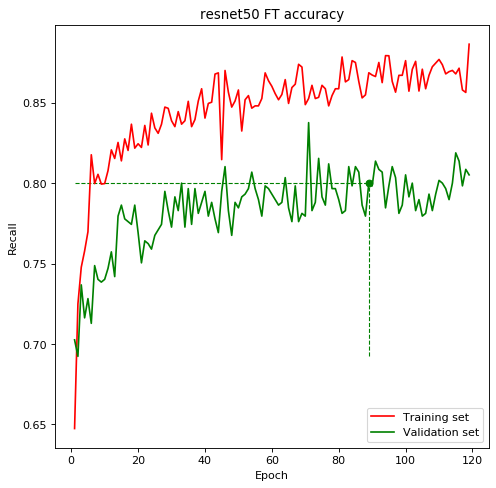

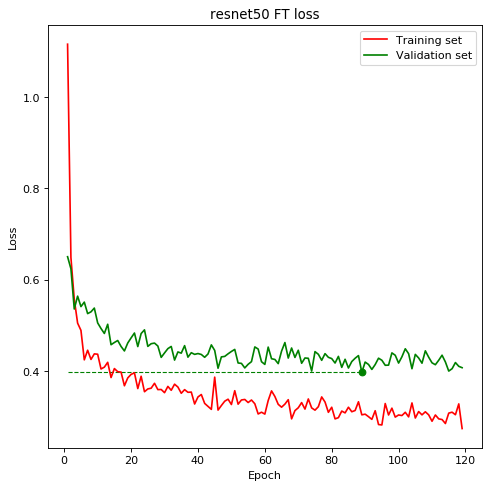

In [35]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [36]:
resnet50_calc_or_mass_best_Nadam = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [37]:
# Train
history_resnet50_calc_or_mass_best_Nadam = resnet50_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.4458 - recall: 0.5715
Epoch 00001: val_loss improved from inf to 0.70104, saving model to ../model/resnet50_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 23s 2s/step - loss: 2.2896 - recall: 0.5813 - val_loss: 0.7010 - val_recall: 0.5915
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5351 - recall: 0.7290
Epoch 00002: val_loss improved from 0.70104 to 0.62293, saving model to ../model/resnet50_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 21s 2s/step - loss: 0.5343 - recall: 0.7325 - val_loss: 0.6229 - val_recall: 0.6598
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5133 - recall: 0.7264
Epoch 00003: val_loss improved from 0.62293 to 0.57785, saving model to ../model/resnet50_calc_or_mass_best_Nadam.h5
11/11 [==========================

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3455 - recall: 0.8422
Epoch 00028: val_loss did not improve from 0.43694
11/11 [==============================] - 21s 2s/step - loss: 0.3504 - recall: 0.8395 - val_loss: 0.4634 - val_recall: 0.7590
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3450 - recall: 0.8460
Epoch 00029: val_loss improved from 0.43694 to 0.43339, saving model to ../model/resnet50_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 21s 2s/step - loss: 0.3431 - recall: 0.8457 - val_loss: 0.4334 - val_recall: 0.7812
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3182 - recall: 0.8476
Epoch 00030: val_loss did not improve from 0.43339
11/11 [==============================] - 21s 2s/step - loss: 0.3144 - recall: 0.8511 - val_loss: 0.4471 - val_recall: 0.7744
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3469 - recall: 0.8508
Epoch 00031: val_loss did not 

Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2881 - recall: 0.8628
Epoch 00058: val_loss did not improve from 0.42031
11/11 [==============================] - 20s 2s/step - loss: 0.2891 - recall: 0.8617 - val_loss: 0.4790 - val_recall: 0.7863
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2893 - recall: 0.8754
Epoch 00059: val_loss did not improve from 0.42031
11/11 [==============================] - 21s 2s/step - loss: 0.2846 - recall: 0.8784 - val_loss: 0.4527 - val_recall: 0.7863
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2837 - recall: 0.8779
Epoch 00060: val_loss did not improve from 0.42031
11/11 [==============================] - 20s 2s/step - loss: 0.2899 - recall: 0.8739 - val_loss: 0.4217 - val_recall: 0.7949
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2949 - recall: 0.8758
Epoch 00061: val_loss did not improve from 0.42031
11/11 [==============================] - 21s 

Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2608 - recall: 0.8875
Epoch 00088: val_loss did not improve from 0.39828
11/11 [==============================] - 21s 2s/step - loss: 0.2605 - recall: 0.8906 - val_loss: 0.4111 - val_recall: 0.8103
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2737 - recall: 0.8844
Epoch 00089: val_loss did not improve from 0.39828
11/11 [==============================] - 21s 2s/step - loss: 0.2728 - recall: 0.8835 - val_loss: 0.4259 - val_recall: 0.8034
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2697 - recall: 0.8742
Epoch 00090: val_loss did not improve from 0.39828
11/11 [==============================] - 21s 2s/step - loss: 0.2676 - recall: 0.8757 - val_loss: 0.4066 - val_recall: 0.8068
Epoch 91/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2852 - recall: 0.8781
Epoch 00091: val_loss did not improve from 0.39828
11/11 [==============================] - 21s 

In [38]:
models.save_model(resnet50_calc_or_mass_best_Nadam, '../model/resnet50_calc_or_mass_end_Nadam.h5')

In [39]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 135
Epoch [opt]: 105
Valid recall [end]: 0.8154
Valid recall [opt]: 0.8359
Test recall [end]:  0.8320
Test recall [opt]:  0.8398
Valid loss [end]: 0.3833
Valid loss [opt]: 0.3734
Test loss [end]:  0.3965
Test loss [opt]:  0.3876


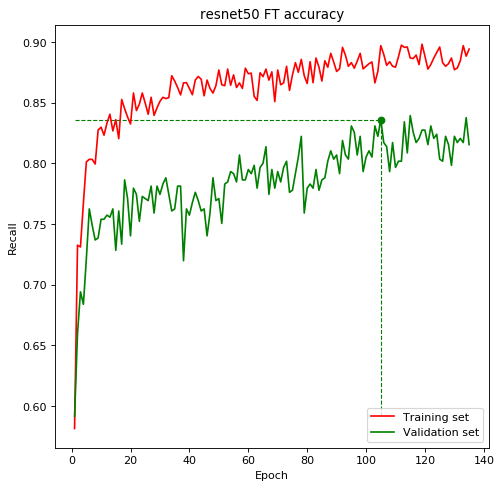

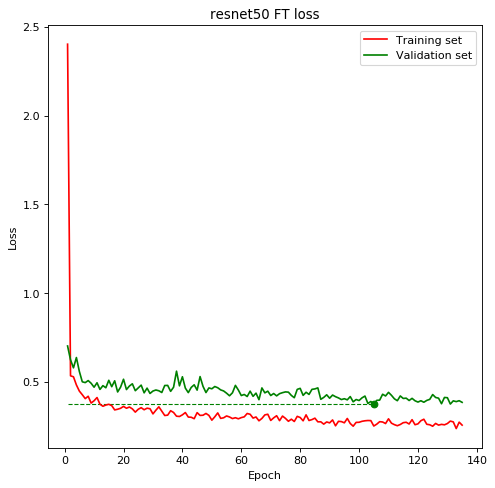

In [40]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [41]:
resnet50_calc_or_mass_fine_Adam = models.load_model('../model/resnet50_calc_or_mass_best_Adam.h5')

for layer in resnet50_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_or_mass_fine_Adam.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [42]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [43]:
history_fit = resnet50_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3291 - recall: 0.8476
Epoch 00001: val_loss improved from inf to 0.41056, saving model to ../model/resnet50_calc_or_mass_fine_Adam_best.h5
11/11 [==============================] - 23s 2s/step - loss: 0.3330 - recall: 0.8473 - val_loss: 0.4106 - val_recall: 0.8171
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3375 - recall: 0.8485
Epoch 00002: val_loss did not improve from 0.41056
11/11 [==============================] - 20s 2s/step - loss: 0.3361 - recall: 0.8503 - val_loss: 0.4312 - val_recall: 0.7932
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3186 - recall: 0.8620
Epoch 00003: val_loss did not improve from 0.41056
11/11 [==============================] - 20s 2s/step - loss: 0.3249 - recall: 0.8571 - val_loss: 0.4297 - val_recall: 0.7966
Epoch 4/300
10/11 [=================

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3348 - recall: 0.8468
Epoch 00029: val_loss did not improve from 0.38895
11/11 [==============================] - 20s 2s/step - loss: 0.3343 - recall: 0.8488 - val_loss: 0.4131 - val_recall: 0.8120
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3589 - recall: 0.8359
Epoch 00030: val_loss did not improve from 0.38895
11/11 [==============================] - 21s 2s/step - loss: 0.3622 - recall: 0.8331 - val_loss: 0.4189 - val_recall: 0.8034
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3335 - recall: 0.8620
Epoch 00031: val_loss did not improve from 0.38895
11/11 [==============================] - 20s 2s/step - loss: 0.3329 - recall: 0.8640 - val_loss: 0.4334 - val_recall: 0.7778
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3499 - recall: 0.8350
Epoch 00032: val_loss did not improve from 0.38895
11/11 [==============================] - 20s 

In [44]:
models.save_model(resnet50_calc_or_mass_fine_Adam, '../model/resnet50_calc_or_mass_fine_Adam_end.h5')

In [45]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_or_mass_fine_Adam = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("resnet50 recall Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 recall Fine Tuning

Epoch [end]: 51
Epoch [opt]: 21
Valid recall [end]: 0.8120
Valid recall [opt]: 0.8222
Test recall [end]:  0.8087
Test recall [opt]:  0.8087
Valid loss [end]: 0.4147
Valid loss [opt]: 0.3889
Test loss [end]:  0.4147
Test loss [opt]:  0.4147


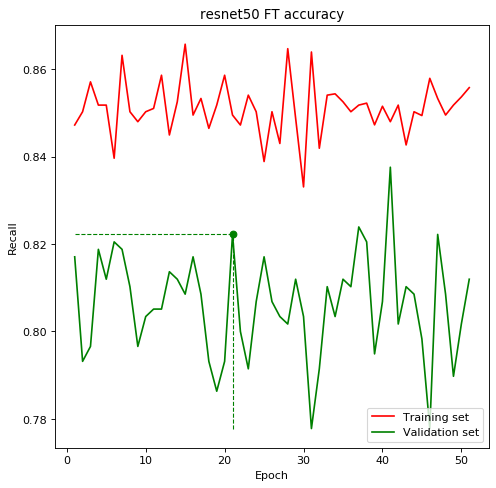

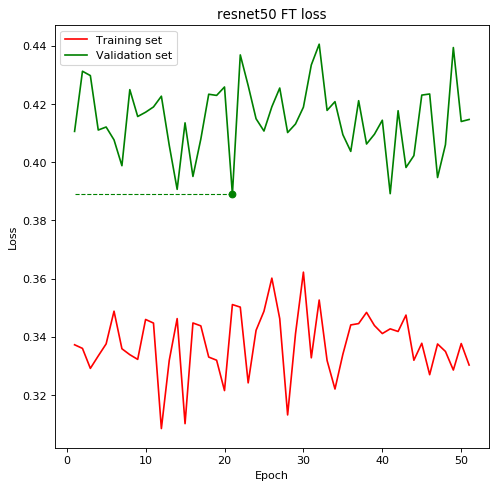

In [46]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [16]:
resnet50_calc_or_mass_fine_Adam2 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best.h5')

for layer in resnet50_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_or_mass_fine_Adam2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [18]:
history_fit = resnet50_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3573 - recall: 0.8391
Epoch 00001: val_loss improved from inf to 0.41554, saving model to ../model/resnet50_calc_or_mass_fine_Adam_best2.h5
11/11 [==============================] - 24s 2s/step - loss: 0.3561 - recall: 0.8388 - val_loss: 0.4155 - val_recall: 0.8068
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3492 - recall: 0.8476
Epoch 00002: val_loss did not improve from 0.41554
11/11 [==============================] - 20s 2s/step - loss: 0.3441 - recall: 0.8503 - val_loss: 0.4461 - val_recall: 0.7897
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3238 - recall: 0.8547
Epoch 00003: val_loss improved from 0.41554 to 0.41366, saving model to ../model/resnet50_calc_or_mass_fine_Adam_best2.h5
11/11 [======

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3246 - recall: 0.8561
Epoch 00028: val_loss did not improve from 0.39817
11/11 [==============================] - 20s 2s/step - loss: 0.3280 - recall: 0.8526 - val_loss: 0.4269 - val_recall: 0.7983
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3118 - recall: 0.8636
Epoch 00029: val_loss did not improve from 0.39817
11/11 [==============================] - 20s 2s/step - loss: 0.3260 - recall: 0.8579 - val_loss: 0.4336 - val_recall: 0.7863
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3345 - recall: 0.8502
Epoch 00030: val_loss did not improve from 0.39817
11/11 [==============================] - 20s 2s/step - loss: 0.3252 - recall: 0.8549 - val_loss: 0.4041 - val_recall: 0.8205
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3091 - recall: 0.8586
Epoch 00031: val_loss did not improve from 0.39817
11/11 [==============================] - 20s 

In [19]:
models.save_model(resnet50_calc_or_mass_fine_Adam2, '../model/resnet50_calc_or_mass_fine_Adam_end2.h5')

In [20]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_or_mass_fine_Adam2 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 46
Epoch [opt]: 16
Valid recall [end]: 0.8239
Valid recall [opt]: 0.8103
Test recall [end]:  0.8087
Test recall [opt]:  0.8087
Valid loss [end]: 0.4054
Valid loss [opt]: 0.3982
Test loss [end]:  0.4147
Test loss [opt]:  0.4147


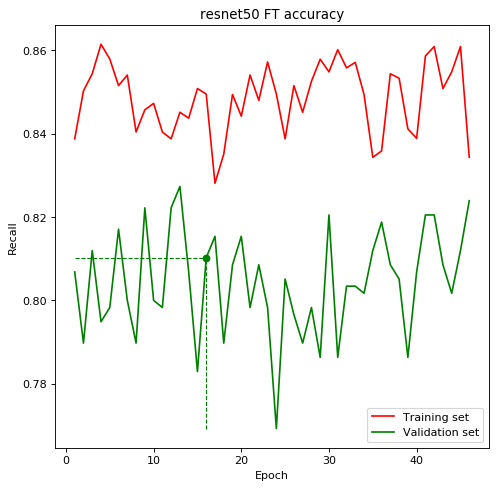

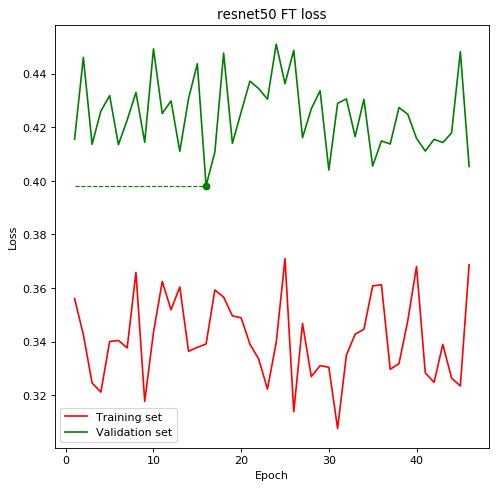

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [22]:
resnet50_calc_or_mass_fine_Adam3 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best2.h5')

for layer in resnet50_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_or_mass_fine_Adam3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [24]:
history_fit = resnet50_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3532 - recall: 0.8477
Epoch 00001: val_loss improved from inf to 0.42002, saving model to ../model/resnet50_calc_or_mass_fine_Adam_best3.h5
11/11 [==============================] - 23s 2s/step - loss: 0.3483 - recall: 0.8501 - val_loss: 0.4200 - val_recall: 0.8137
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3266 - recall: 0.8547
Epoch 00002: val_loss did not improve from 0.42002
11/11 [==============================] - 21s 2s/step - loss: 0.3276 - recall: 0.8544 - val_loss: 0.4490 - val_recall: 0.8000
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3102 - recall: 0.8664
Epoch 00003: val_loss did not improve from 0.42002
11/11 [==============================] - 21s 2s/step - loss: 0.3102 - recall: 0.8665 - val_loss: 0.4286 - val_recall: 0.7932
Epoch 4/300
10/11 [================

10/11 [==========================>...] - ETA: 1s - loss: 0.3430 - recall: 0.8544
Epoch 00029: val_loss did not improve from 0.39254
11/11 [==============================] - 20s 2s/step - loss: 0.3470 - recall: 0.8541 - val_loss: 0.4318 - val_recall: 0.8239
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3619 - recall: 0.8430
Epoch 00030: val_loss did not improve from 0.39254
11/11 [==============================] - 21s 2s/step - loss: 0.3579 - recall: 0.8466 - val_loss: 0.4142 - val_recall: 0.8085
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3475 - recall: 0.8426
Epoch 00031: val_loss did not improve from 0.39254
11/11 [==============================] - 20s 2s/step - loss: 0.3454 - recall: 0.8427 - val_loss: 0.4312 - val_recall: 0.7932
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3346 - recall: 0.8516
Epoch 00032: val_loss did not improve from 0.39254
11/11 [==============================] - 19s 2s/step - los

In [25]:
models.save_model(resnet50_calc_or_mass_fine_Adam3, '../model/resnet50_calc_or_mass_fine_Adam_end3.h5')

In [26]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_or_mass_fine_Adam3 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 40
Epoch [opt]: 10
Valid recall [end]: 0.8103
Valid recall [opt]: 0.8171
Test recall [end]:  0.8087
Test recall [opt]:  0.8087
Valid loss [end]: 0.4191
Valid loss [opt]: 0.3925
Test loss [end]:  0.4147
Test loss [opt]:  0.4147


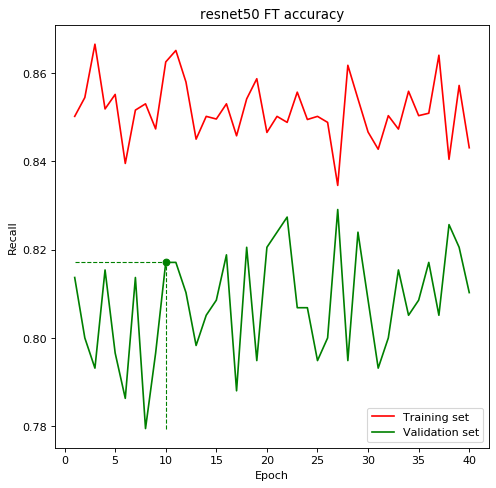

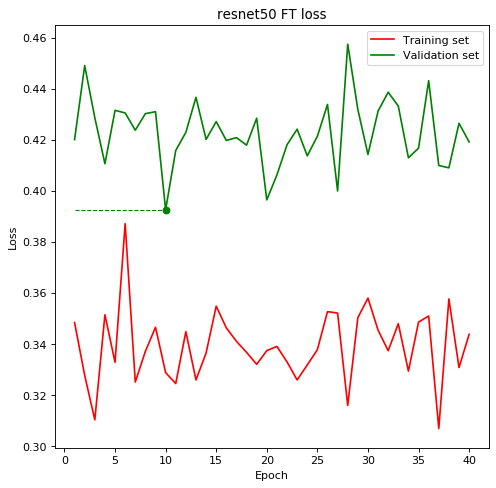

In [27]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();